In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import squidpy as sq
# import decoupler as dc
import plotnine as p9

/home/dbdimitrov/anaconda3/envs/test-env/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.2' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
import liana as li

In [64]:
## load slide
slide = "B1"
exp = "V11L12-109" # V11T17-102 V11L12-109 V11T16-085
slide_path = f"data/VicariEtAl/sma/{exp}/{exp}_{slide}/output_data"
rna_path = slide_path + f"/{exp}_{slide}_RNA/outs/"

rna = sq.read.visium(rna_path, counts_file="filtered_feature_bc_matrix.h5")

msi_raw = pd.read_csv(slide_path + f"/{exp}_{slide}_MSI/{exp}_{slide}.Visium.FMP.220826_smamsi.csv")


/home/dbdimitrov/anaconda3/envs/test-env/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/dbdimitrov/anaconda3/envs/test-env/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [65]:
# Only for mouse
lesion = pd.read_csv(rna_path + "/lesion.csv").set_index("Barcode")
region = pd.read_csv(rna_path +  "/region.csv").set_index("Barcode")
rna.obs = rna.obs.join(lesion)
rna.obs = rna.obs.join(region)

In [66]:
rna.obs

,in_tissue,array_row,array_col,lesion,region
AAACAAGTATCTCCCA-1,1,50,102,lesioned,striatum
AAACAGCTTTCAGAAG-1,1,43,9,intact,not_striatum
AAACATTTCCCGGATT-1,1,61,97,lesioned,striatum
AAACCCGAACGAAATC-1,1,45,115,lesioned,not_striatum
AAACCGGAAATGTTAA-1,1,54,124,lesioned,not_striatum
...,...,...,...,...,...
TTGTTCAGTGTGCTAC-1,1,24,64,intact,not_striatum
TTGTTCTAGATACGCT-1,1,21,3,intact,not_striatum
TTGTTGTGTGTCAAGA-1,1,31,77,lesioned,not_striatum
TTGTTTCCATACAACT-1,1,45,27,intact,striatum


In [67]:
sc.pp.normalize_total(rna, target_sum=1e4)
sc.pp.log1p(rna)
sc.pp.scale(rna)

In [68]:
sc.pp.pca(rna)
sc.pp.neighbors(rna, n_neighbors=10, n_pcs=20)

In [69]:
sc.tl.leiden(rna, resolution=0.1)
sc.tl.umap(rna)

... storing 'lesion' as categorical
... storing 'region' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
/home/dbdimitrov/anaconda3/envs/test-env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/home/dbdimitrov/anaconda3/envs/test-env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/home/dbdimitrov/anaconda3/envs/test-env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


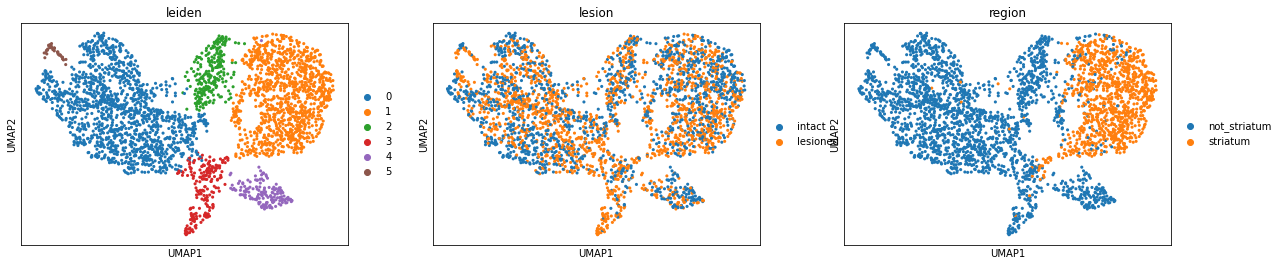

In [70]:
sc.pl.umap(rna, color=["leiden", "lesion", "region"])

MSI

In [261]:
# get positions
positions = msi_raw[['y', 'x']].copy().values

# estimate scaling factor
sfactor = rna.uns['spatial']['V11L12-109_B1']['scalefactors']['fiducial_diameter_fullres']
sfactor

608.9063

In [262]:
# inverse y
positions[:, 0] = (positions[:, 0].max() - positions[:, 0])
# offset
positions[:, 1] = positions[:, 1] + 10.5
positions[:, 0] = positions[:, 0] + 3

# scale
positions = positions * sfactor * 0.95

msi = msi_raw.copy().drop(['x', 'y'], axis=1)
msi = sc.AnnData(X=msi.values,
                 obs=pd.DataFrame(index=msi.index),
                 var=pd.DataFrame(index=msi.columns))

/home/dbdimitrov/anaconda3/envs/test-env/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.


In [263]:
msi.obs[['array_row', 'array_col']] = positions

In [264]:
msi.obs['array_col'].max()

41649.190919999994

In [265]:
msi.uns = rna.uns.copy()

In [266]:
msi.obsm['spatial'] = positions

In [267]:
sc.pp.normalize_total(msi, target_sum=1e4)
sc.pp.log1p(msi)
sc.pp.scale(msi)
sc.pp.pca(msi)
sc.pp.neighbors(msi, n_neighbors=10, n_pcs=20)
sc.tl.leiden(msi, resolution=0.00001)

/home/dbdimitrov/anaconda3/envs/test-env/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts


In [268]:
# remove cells that are not in the tissue
msi = msi[msi.obs['leiden'] != '1', :]

/home/dbdimitrov/anaconda3/envs/test-env/lib/python3.8/site-packages/scanpy/plotting/_utils.py:430: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.


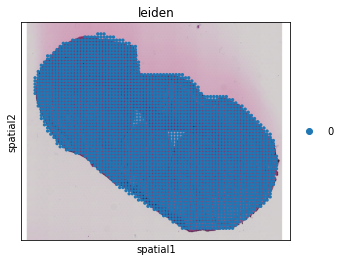

In [269]:
sc.pl.spatial(msi, color="leiden", spot_size=sfactor)

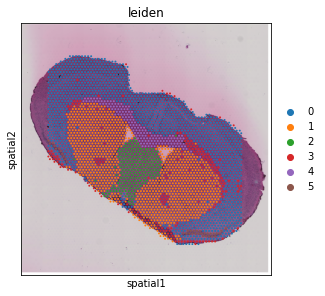

In [270]:
sq.pl.spatial_scatter(rna, color="leiden")

In [273]:
import muon as mu

In [274]:
mdata = mu.MuData({'rna':rna, 'msi':msi})

/home/dbdimitrov/anaconda3/envs/test-env/lib/python3.8/site-packages/mudata/_core/mudata.py:479: UserWarning: var_names are not unique. To make them unique, call `.var_names_make_unique`.


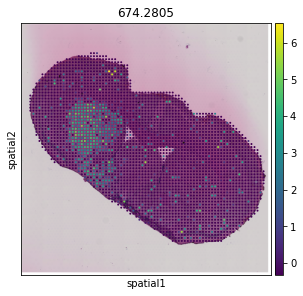

In [276]:
sq.pl.spatial_scatter(msi, color=[# '674.2522', '674.26665', '674.26906',
                                  '674.2805', # Dopamine
                                #   '674.28592', '674.28833'
                                  ])

In [ ]:
#  check for strings that contain 674 (Dopamine)
msk = ['674' in x for x in msi.var.index]
msi.var.index[msk]

In [ ]:
sq.pl.spatial_scatter(rna, color=['lesion', 'region'])